In [1]:
import sys
import numpy as np
np.random.seed(0)
import torch
import itertools
#%matplotlib notebook

# Create dataset

In [2]:
import numpy as np
import math
import ipympl
import matplotlib.pyplot as plt
import random

def create_dataset(xmin,xmax,N):

    A0 = 1.0
       
    T1 = 3
    phi1 = 2*math.pi/float(T1)
    A1 = 1/phi1
    
    T2 = 6
    phi2 = 2*math.pi/float(T2)
    A2 = 1/phi2
    
    xt = np.linspace(xmin, xmax, N)
    yt = np.zeros(xt.shape)
    for i in xrange(N):
        yt[i] = xt[i]**2 #A0 + A1*math.sin(phi1*xt[i]) + A2*math.cos(phi2*xt[i])

    samples = np.random.normal(0,0.001,N/2)
    idx = random.sample(range(N), N/2)

    xs = np.zeros((N,2))
    xs[0:N/2,1] = yt[idx]+10+samples 
    xs[0:N/2,0] = xt[idx]
    nidx = np.setdiff1d(np.arange(0,N,1),idx)
    xs[N/2:N,1] = yt[nidx]-5-samples 
    xs[N/2:N,0] = xt[nidx]

    ys = np.zeros((N,))
    ys[0:N/2] = 1

    idx = random.sample(range(N), N/20)
    x = xs[idx,:]
    y = ys[idx]
    
    nidx = np.setdiff1d(np.arange(0,N,1),idx)
    tidx = random.sample(nidx, N/80)
    x_tst = xs[tidx,:]
    y_tst = ys[tidx]
    
    print(list(set(idx).intersection(tidx)))
    
        
    return x, y, xt, yt, x_tst, y_tst


def create_grid(xmin, xmax, N):
    """
    Creates a grid for 3d plotting.
    :param xmin: lower limit
    :param xmax: upper limit
    :param N: number of points in the grid per dimension
    :return: the grid
    """

    xx = np.linspace(xmin, xmax, N)
    X, Y = np.meshgrid(xx, xx)
    data = np.concatenate([X.reshape([-1, 1]), Y.reshape([-1, 1])], axis=1)

    return data, X, Y



def show_train_data():
    """
    Plots the training data.
    """
    xmin = -10.0
    xmax = 10.0
    N = 1000
    xs, ys, xt, yt, x_tst, y_tst = create_dataset(xmin,xmax,N)

    fig = plt.figure(figsize=(15,5)) 

    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(xs[ys == 0, 0], xs[ys == 0, 1], 'b.', ms=12)
    ax1.plot(xs[ys == 1, 0], xs[ys == 1, 1], 'r.', ms=12)
    ax1.plot(xt,yt)
    ax1.set_xlabel('x1')
    ax1.set_ylabel('x2')
    ax1.set_title('Training data')

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(x_tst[y_tst == 0, 0], x_tst[y_tst == 0, 1], 'b.', ms=12)
    ax2.plot(x_tst[y_tst == 1, 0], x_tst[y_tst == 1, 1], 'r.', ms=12)
    ax2.plot(xt,yt)
    ax2.set_xlabel('x1')
    ax2.set_ylabel('x2')
    ax2.set_title('Test data')

    
    
    plt.show()
    
    return xs, ys, xt, yt, x_tst, y_tst

[]


<IPython.core.display.Javascript object>


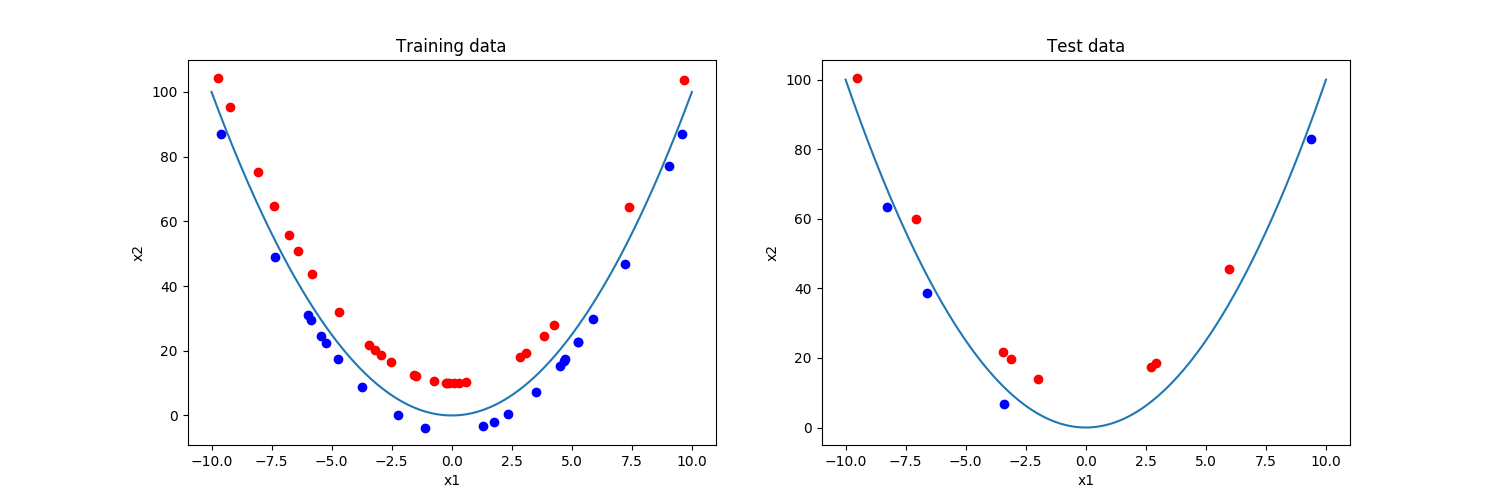

In [22]:
from sklearn.preprocessing import StandardScaler

nb_epochs = 200
nb_reps = 1
K_test = [20,50,200,400,500,1000]
batch_size = 32
Q = 2 

X_tr, Y_tr, xt, yt, x_tst_prescale, y_tst = show_train_data()

scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)
x_tst = scaler.transform(x_tst_prescale)

# Class implementing ConcreteDropout (Gal et al 2017)

In [4]:
import keras.backend as K
from keras import initializers
from keras.engine import InputSpec
from keras.layers import Dense, Lambda, Wrapper, Concatenate


class ConcreteDropout(Wrapper):
    """This wrapper allows to learn the dropout probability for any given input layer.
    ```python
        # as the first layer in a model
        model = Sequential()
        model.add(ConcreteDropout(Dense(8), input_shape=(16)))
        # now model.output_shape == (None, 8)
        # subsequent layers: no need for input_shape
        model.add(ConcreteDropout(Dense(32)))
        # now model.output_shape == (None, 32)
    ```
    `ConcreteDropout` can be used with arbitrary layers, not just `Dense`,
    for instance with a `Conv2D` layer:
    ```python
        model = Sequential()
        model.add(ConcreteDropout(Conv2D(64, (3, 3)),
                                  input_shape=(299, 299, 3)))
    ```
    # Arguments
        layer: a layer instance.
        weight_regularizer:
            A positive number which satisfies
                $weight_regularizer = l**2 / (\tau * N)$
            with prior lengthscale l, model precision $\tau$ (inverse observation noise),
            and N the number of instances in the dataset.
            Note that kernel_regularizer is not needed.
        dropout_regularizer:
            A positive number which satisfies
                $dropout_regularizer = 2 / (\tau * N)$
            with model precision $\tau$ (inverse observation noise) and N the number of
            instances in the dataset.
            Note the relation between dropout_regularizer and weight_regularizer:
                $weight_regularizer / dropout_regularizer = l**2 / 2$
            with prior lengthscale l. Note also that the factor of two should be
            ignored for cross-entropy loss, and used only for the eculedian loss.
    """

    def __init__(self, layer, weight_regularizer=1e-6, dropout_regularizer=1e-5,
                 init_min=0.1, init_max=0.1, is_mc_dropout=True, **kwargs):
        assert 'kernel_regularizer' not in kwargs
        super(ConcreteDropout, self).__init__(layer, **kwargs)
        self.weight_regularizer = weight_regularizer
        self.dropout_regularizer = dropout_regularizer
        self.is_mc_dropout = is_mc_dropout
        self.supports_masking = True
        self.p_logit = None
        self.p = None
        self.init_min = np.log(init_min) - np.log(1. - init_min)
        self.init_max = np.log(init_max) - np.log(1. - init_max)

    def build(self, input_shape=None):
        self.input_spec = InputSpec(shape=input_shape)
        if not self.layer.built:
            self.layer.build(input_shape)
            self.layer.built = True
        super(ConcreteDropout, self).build()  # this is very weird.. we must call super before we add new losses

        # initialise p
        self.p_logit = self.layer.add_weight(name='p_logit',
                                            shape=(1,),
                                            initializer=initializers.RandomUniform(self.init_min, self.init_max),
                                            trainable=True)
        self.p = K.sigmoid(self.p_logit[0])

        # initialise regulariser / prior KL term
        input_dim = np.prod(input_shape[1:])  # we drop only last dim
        weight = self.layer.kernel
        kernel_regularizer = self.weight_regularizer * K.sum(K.square(weight)) / (1. - self.p)
        dropout_regularizer = self.p * K.log(self.p)
        dropout_regularizer += (1. - self.p) * K.log(1. - self.p)
        dropout_regularizer *= self.dropout_regularizer * input_dim
        regularizer = K.sum(kernel_regularizer + dropout_regularizer)
        self.layer.add_loss(regularizer)

    def compute_output_shape(self, input_shape):
        return self.layer.compute_output_shape(input_shape)

    def concrete_dropout(self, x):
        '''
        Concrete dropout - used at training time (gradients can be propagated)
        :param x: input
        :return:  approx. dropped out input
        '''
        eps = K.cast_to_floatx(K.epsilon())
        temp = 0.1

        unif_noise = K.random_uniform(shape=K.shape(x))
        drop_prob = (
            K.log(self.p + eps)
            - K.log(1. - self.p + eps)
            + K.log(unif_noise + eps)
            - K.log(1. - unif_noise + eps)
        )
        drop_prob = K.sigmoid(drop_prob / temp)
        random_tensor = 1. - drop_prob

        retain_prob = 1. - self.p
        x *= random_tensor
        x /= retain_prob
        return x

    def call(self, inputs, training=None):
        if self.is_mc_dropout:
            return self.layer.call(self.concrete_dropout(inputs))
        else:
            def relaxed_dropped_inputs():
                return self.layer.call(self.concrete_dropout(inputs))
            return K.in_train_phase(relaxed_dropped_inputs,
                                    self.layer.call(inputs),
                                    training=training)

Using Theano backend.


# Plot helper

In [23]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

%matplotlib notebook

def plot_trainLoss(reps=None,train_loss=None):
    
   fig = plt.figure(figsize=(20,4)) 

   ax1 = fig.add_subplot(1, 4, 1)
   #Plot loss on training set    
   ax1.plot(reps, train_loss, c='r', label='Training')
   ax1.set_title('Loss')
   ax1.set_xlabel('x1')
   ax1.set_ylabel('x2')
   
   plt.show()
    
   return fig
    
    
    
def plot_testData(fig=None,add_fig=False,ax=None,xtest=None,ytest=None,xt=None,yt=None):
   
   if add_fig:
      fig = plt.figure(figsize=(15,3)) 
   if ax==None:
      ax = fig.add_subplot(1, 2, 2) 
   
   ax.plot(xt,yt)
   ax.plot(xtest[ytest == 0, 0], xtest[ytest == 0, 1], 'y.', ms=6)
   ax.plot(xtest[ytest == 1, 0], xtest[ytest == 1, 1], 'g.', ms=6)
   ax.set_title('Test data')
   ax.set_xlabel('x1')
   ax.set_ylabel('x2')
   
   plt.show()
   
   return fig, ax    


    
def plot_decisionSurface(surf=None,fig=None,ax=None,preds=None,X=None,Y=None,xs=None,ys=None):

   Z = preds.reshape(list(X.shape))
   #Plot decision surface
   if fig==None:
      fig = plt.figure(figsize=(15,4)) 
   if ax==None:
      ax = fig.add_subplot(1, 4, 2, projection='3d') 
         
   if surf:
      ax.collections.remove(surf)
      surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0)
    
   else:
      surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0)
      ax.plot(xs[ys == 0, 0], xs[ys == 0, 1], 1, 'b.', ms=8)
      ax.plot(xs[ys == 1, 0], xs[ys == 1, 1], 1, 'r.', ms=8)
      ax.view_init(elev=85, azim=-45)
      ax.set_title('Decision surface')
      ax.set_xlabel('x1')
      ax.set_ylabel('x2')
      ax.set_zlabel('y')
   
   fig.canvas.draw()

   return fig, ax, surf
   

def plot_parameters(img=None, cbar=None, fig=None,ax_img=None, W=None):

    
   if fig==None:
      fig = plt.figure(figsize=(15,4)) 
   if ax_img==None:
      ax_img = fig.add_subplot(1, 4, 3) 
         
   if img:
      fig.delaxes(ax_img)
      cbar.remove()
      ax_img = fig.add_subplot(1, 4, 3)   
      img = ax_img.imshow(W, cmap='hot', interpolation='nearest')
      PCM = ax_img.get_children()[9]
      cbar = plt.colorbar(PCM, ax=ax_img)
      
   else:    
      img = ax_img.imshow(W, cmap='hot', interpolation='nearest')
      PCM = ax_img.get_children()[9]
      cbar = plt.colorbar(PCM, ax=ax_img)
      
   
   fig.canvas.draw()
       
   return fig, ax_img, img, cbar



def plot_dropMask(img=None, cbar=None, fig=None, ax_img=None, W=None):

   if fig==None:
      fig = plt.figure(figsize=(15,4)) 
   if ax_img==None:
      ax_img = fig.add_subplot(1, 4, 4) 
   if img:
      fig.delaxes(ax_img)
      cbar.remove()
      ax_img = fig.add_subplot(1, 4, 4)   
      img = ax_img.imshow(W, cmap='hot', interpolation='nearest')
      PCM = ax_img.get_children()[9]
      cbar = plt.colorbar(PCM, ax=ax_img)
   else:
      img = ax_img.imshow(W, cmap='hot', interpolation='nearest')
      PCM = ax_img.get_children()[9]
      cbar = plt.colorbar(PCM, ax=ax_img)
      
         
         
   fig.canvas.draw()
       
   return fig, ax_img, img, cbar
    
def plot_tuneLengthScale(results,l):    

     pred_entr = np.array([i[1] for i in results])
     
     fig = plt.figure(figsize=(15,4)) 
   
     #Length scale vs test predictive entropy
     ax3 = fig.add_subplot(1, 1, 1)
     """
     model = make_pipeline(PolynomialFeatures(3), Ridge())
     l_plot = l[:, np.newaxis]
     model.fit(l_plot, pred_entr)
     x_plot = np.linspace(np.amin(l), np.amax(l), 100)
     X_plot = x_plot[:, np.newaxis]
     y_plot = model.predict(X_plot)
     ax3.plot(x_plot, y_plot, color='yellow', linewidth=2)
     """
     ax3.scatter(l, pred_entr, c='r', label='Length scale vs test predictive entropy')
     ax3.set_title('Length scale vs test predictive entropy')
     ax3.set_xlabel('length_scale')
     ax3.set_ylabel('entropy')
   
     plt.show()
    

def plot_tuneNeurons(results,neurons):    

     pred_entr = np.array([i[1] for i in results])
     fig = plt.figure(figsize=(15,4)) 

     #Neurons vs test predictive entropy
     ax4 = fig.add_subplot(1, 1, 1)
     model = make_pipeline(PolynomialFeatures(3), Ridge())
     n_plot = neurons[:, np.newaxis]
     model.fit(n_plot, pred_entr)
     x_plot = np.linspace(np.min(neurons), np.amax(neurons), 100)
     X_plot = x_plot[:, np.newaxis]
     y_plot = model.predict(X_plot)
     ax4.plot(x_plot, y_plot, color='green', linewidth=2)
     ax4.scatter(neurons, pred_entr, c='r', label='Number of neurons vs test predictive entropy')
     ax4.set_title('Number of neurons vs test predictive entropy')
     ax4.set_xlabel('#neurons')
     ax4.set_ylabel('entropy')
   
     plt.show()
    
def plot_tuneK(results,K):    

     pred_entr = np.array([i[1] for i in results])
     fig = plt.figure(figsize=(15,4)) 

     #Number of MC samples vs test predictive entropy
     ax5 = fig.add_subplot(1, 1, 1)
     model = make_pipeline(PolynomialFeatures(3), Ridge())
     n_plot = K[:, np.newaxis]
     model.fit(n_plot, pred_entr)
     x_plot = np.linspace(np.min(K), np.amax(K), 100)
     X_plot = x_plot[:, np.newaxis]
     y_plot = model.predict(X_plot)
     ax5.plot(x_plot, y_plot, color='green', linewidth=2)
     ax5.scatter(K, pred_entr, c='r', label='Number of MC samples vs test predictive entropy')
     ax5.set_title('Number of MC samples vs test predictive entropy')
     ax5.set_xlabel('#MC samples')
     ax5.set_ylabel('entropy')
   
     plt.show()
   
    
    
def plot_results(results,l=None,neurons=None):
   
   loss = np.array([i[1] for i in results])
   drop_prob = np.array([i[0] for i in results])
   pred_entr = np.array([i[3] for i in results])


   fig = plt.figure(figsize=(15,4)) 

   ax1 = fig.add_subplot(1, 2, 1)
   #Plot ELBO vs predictive entropy    
   model = make_pipeline(PolynomialFeatures(3), Ridge())
   loss_plot = loss[:, np.newaxis]
   model.fit(loss_plot, pred_entr)
   x_plot = np.linspace(min(loss), max(loss), 1000)
   X_plot = x_plot[:, np.newaxis]
   y_plot = model.predict(X_plot)
   ax1.plot(x_plot, y_plot, color='teal', linewidth=2)
   ax1.scatter(loss[:], pred_entr[:], c='r', label='Training loss vs test predictive entropy') 
   ax1.set_title('Training loss vs test predictive entropy')
   ax1.set_xlabel('loss')
   ax1.set_ylabel('entropy')
   
   #Plot dropout probability vs predictive entropy
   ax2 = fig.add_subplot(1, 2, 2)
   model = make_pipeline(PolynomialFeatures(3), Ridge())
   drop_plot = drop_prob[:, np.newaxis]
   model.fit(drop_plot, pred_entr)
   x_plot = np.linspace(min(drop_prob)-3, max(drop_prob)+3, 100)
   X_plot = x_plot[:, np.newaxis]
   y_plot = model.predict(X_plot)
   ax2.plot(x_plot, y_plot, color='yellow', linewidth=2)
   ax2.scatter(drop_prob, pred_entr, c='r', label='Dropout probability vs test predictive entropy')
   ax2.set_title('Dropout probability vs test predictive entropy')
   ax2.set_xlabel('dropout prob')
   ax2.set_ylabel('entropy')
   
   
   plt.show()
    
    

# Training and testing functions

In [18]:
from keras.layers import Input,merge
from keras.models import Model


def fit_model(nb_epoch, X, Y, validation_data=None, neurons=3,length_scale=1e-6):
    if K.backend() == 'tensorflow':
        K.clear_session()
    N = X.shape[0]
    wd = length_scale**2. / N   ############# tau==1 here, more values?
    dd = 2. / N
    inp = Input(shape=(Q,))
    x = inp
    x = Dense(neurons,activation='relu',name='CD1')(x)
    x = ConcreteDropout(Dense(1, activation='sigmoid',name='CD2'), weight_regularizer=wd, dropout_regularizer=dd)(x)
    out = x 
    model = Model(inp, out)
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    assert len(model.layers[2].trainable_weights) == 3  # kernel, bias, and dropout prob
    assert len(model.losses) == 1  # a loss for each Concrete Dropout layer
    if validation_data==None:
        hist = model.fit(X, Y, epochs=nb_epoch, batch_size=batch_size, verbose=0)    
    else:
        hist = model.fit(X, Y, epochs=nb_epoch, batch_size=batch_size, verbose=0, validation_data=validation_data)
    loss = hist.history['loss'][-1]
    return hist,model, -0.5 * loss, hist.history['loss']   # return ELBO up to const.

In [19]:
def conc_dropout(x, p):
        eps = float(K.epsilon())
        temp = 0.1

        unif_noise = K.random_uniform(shape=x.shape)
        drop_prob = (
            K.log(p + eps)
            - K.log(1. - p + eps)
            + K.log(unif_noise + eps)
            - K.log(1. - unif_noise + eps)
        )
        drop_prob = K.sigmoid(drop_prob / temp)
        random_tensor = 1. - drop_prob

        retain_prob = 1. - p
        x *= random_tensor
        x /= retain_prob
        #print(K.eval(random_tensor))
        return x, random_tensor


def custom_predict(test_data,W=None,b=None,M=None):
    
    mask = None
    if (W==None) and (M==None) and (b==None):
        
        W1 = np.array(model.layers[1].get_weights()[0])
        b1 = np.array(model.layers[1].get_weights()[1])
        W2 = np.array(model.layers[2].get_weights()[0])
        b2 = np.array(model.layers[2].get_weights()[1])
        plogit = np.array(model.layers[2].get_weights()[2])
        p = K.eval(K.sigmoid(plogit))
        W = [W1,W2]
        b = [b1,b2]
        mask, M_ = K.eval(conc_dropout(W2, p)[0]), K.eval(conc_dropout(W2, p)[1])
        M = [M_]
        #print(M[0])
        #print(mask)
    
    MC_samples = K.eval(K.sigmoid(np.dot(K.relu(np.dot(test_data,W[0])+b[0]),M[0])+b[1]))
           
    return W, b, M, mask, MC_samples 


def test(Y_true, MC_samples):
    
    assert len(MC_samples.shape) == 3
    
    k = MC_samples.shape[0]
    N = Y_true.shape[0]
    #Get probability of each class after MC sampling, so that we can get the mean
      
    y_pred = np.zeros((N,1))
    MC_means = np.sum(MC_samples,axis=0)/float(k)
    y_pred[MC_means>=0.5] = 1   
    
    acc = len(np.where(Y_true==y_pred.flatten())[0])/float(N)*100
    print("\n ( Micro Averaging ) Accuracy: {}".format(acc))

    #For variation ratio
    predictions_per_test_point = np.zeros((k,N))
    for i in xrange(N):
        predictions_per_test_point[MC_samples[:,i,0]>=0.5,i] = 1
            
    mode_fx = []
    MC_majVote = np.zeros(y_pred.shape)
    for i in xrange(N):
        values,votes = np.unique(predictions_per_test_point[:,i], return_counts=True)
        m = np.argmax(votes)
        mode_fx.append((values[m],votes[m]))
        MC_majVote[i] = values[m]
    acc2 = len(np.where(MC_majVote.flatten()==Y_true)[0])/float(N)*100
    print("\n ( Macro Averaging ) Accuracy: {}".format(acc2))
    
          
    return acc, acc2, MC_means, mode_fx

        

# Training process

We estimate the following uncertainty metrics:

$\textbf{Variation ratio} :$
$$
VR = 1 - \frac{f_{mode}}{T}
$$
The lower the variation ratio, the less spread in the modes of the posterior. For the binary case, maximum value is 0.5, where both classes are sampled equally, minimum value is 0 where just one class is sampled.

$\textbf{Predictive entropy} :$
$$
\hat{\mathcal{H}}[\,y\,|\,x, D_{train}\,]=-\sum_c\Big(\frac{1}{T}\sum_tp(\,y=c\,|\,x,\hat{\omega_t}\,)\Big)\log\Big(\frac{1}{T}\sum_tp(\,y=c\,|\,x,\hat{\omega_t}\,)\Big)
$$
The lower the predictive entropy the more certain the prediction (minimum value 0). It is set to its maximum value when all classes are predicted to have equal uniform probability.

$\textbf{Mutual Information} :$
$$
\hat{\mathcal{I}}[\,y,\omega|x,D_{train}\,]= -\sum_c\Big(\frac{1}{T}\sum_tp(\,y=c
\,|\,x,\hat{\omega_t}\,)\Big)\log\Big(\frac{1}{T}\sum_tp(\,y=c\,|\,x,\hat{\omega_t}\,)\Big)+\\ \frac{1}{T}\sum_{c,t}p(\,y=c\,|\,x,\hat{\omega_t}\,)\log p(\,y=c\,|\,x,\hat{\omega_t}\,)
$$
The mutual information is maximised at points x where the model is uncertain on average, however there exist model parameters that erroneously produce predictions with high confidence. Therefore, the lower the MI (minimum value 0), the more confident the model is, i.e. gives more consistent predictions during sampling.


In [26]:
def get_uncertainty_metrics(mode_fx,MC_means,K_test):
    
        #Average variation ratio over the minibatch
        variation_ratio = np.zeros((len(mode_fx),1))
        for j in xrange(len(mode_fx)):
            variation_ratio[j] = 1 - ((mode_fx[j])[1])/float(K_test)
        variation_ratio_avg_VR = np.sum(variation_ratio)/float(len(mode_fx))
        #print(variation_ratio_avg_VR)
       
        #Average predictive entropy over minibatch
        predictive_entropy = -1*np.sum(MC_means*np.log(MC_means),axis=-1)
        predictive_entropy_avg_H = np.sum(predictive_entropy)/float(len(mode_fx))
        #print(predictive_entropy_avg_H)
        
        #Average mutual information over minibatch
        expected_entropy = np.sum(np.sum(MC_samples*np.log(MC_samples),axis=-1),axis=0)/float(K_test)
        mutual_information_avg_MI = predictive_entropy_avg_H + np.sum(expected_entropy)/float(len(mode_fx))
        #print(mutual_information_avg_MI)
        
        
        return variation_ratio_avg_VR,predictive_entropy_avg_H,mutual_information_avg_MI


 ( Micro Averaging ) Accuracy: 66.6666666667

 ( Macro Averaging ) Accuracy: 33.3333333333

 ( Micro Averaging ) Accuracy: 58.3333333333

 ( Macro Averaging ) Accuracy: 66.6666666667

 ( Micro Averaging ) Accuracy: 66.6666666667

 ( Macro Averaging ) Accuracy: 41.6666666667

 ( Micro Averaging ) Accuracy: 75.0

 ( Macro Averaging ) Accuracy: 75.0

 ( Micro Averaging ) Accuracy: 66.6666666667

 ( Macro Averaging ) Accuracy: 33.3333333333

 ( Micro Averaging ) Accuracy: 66.6666666667

 ( Macro Averaging ) Accuracy: 33.3333333333


<IPython.core.display.Javascript object>


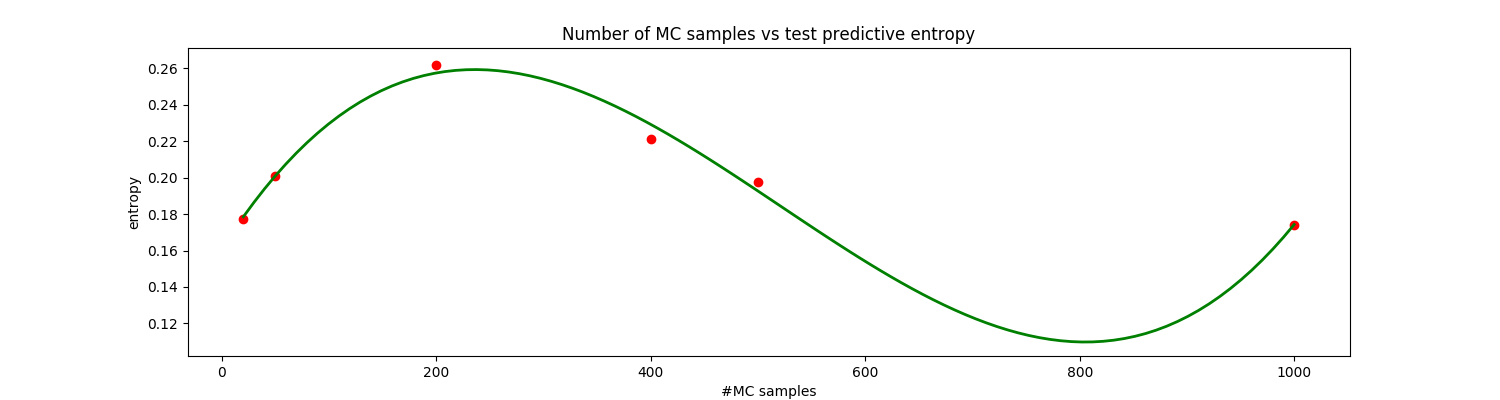

In [27]:
import time
results = []
l = 1e-2
neurons_list = [3,6,10,20,50,80] #,100,500,1000,10000,50000]
l_list = [1e-5,1e-4,1e-3,1e-2,0.05,0.09]
neurons = 6
# get results for multiple N
#for N, nb_epoch in zip(Ns, nb_epochs):
#for neurons in neurons_list:
#    print(neurons)
#for l in l_list:  
#    print(l)
for Kt in K_test:
    # repeat exp multiple times
    rep_results = []
    for i in xrange(nb_reps):
        fig = None
        X_train, Y_train = X_tr, Y_tr
        hist, model, ELBO_final, loss = fit_model(nb_epochs, X_train, Y_train, neurons=neurons,length_scale=l) 
        #percentage of neurons kept active
        ps = np.array([K.eval(layer.p) for layer in model.layers if hasattr(layer, 'p')])
        #fig = plot_trainLoss(reps=range(nb_epochs),train_loss=loss)

        #Data to plot decision surface 
        meshgrid_data,X,Y = create_grid(np.amin(X_tr),np.amax(X_tr),100)
        MC_samples_complete = []
        ax = None
        surf = None
        img = None
        ax_img = None
        ax_img_d = None 
        img_d = None
        cbar_d = None
        cbar = None
        for _ in xrange(Kt):
            W = []
            b = [] 
            M = []
            W, b, M, p, MC_samples = custom_predict(x_tst)
            ytest = np.zeros((len(MC_samples),1))
            MC_samples_complete += [MC_samples]
            for i in xrange(len(MC_samples)):
                if MC_samples[i]>=0.5:
                   ytest[i] = 1
            #fig, ax = plot_testData(fig=fig,add_fig=False,ax=ax,xtest=x_tst_prescale,ytest=ytest.flatten(),xt=xt,yt=yt)
            
            #_, _, _,_, grid_data = custom_predict(meshgrid_data,W,b,M)
            #fig, ax, surf = plot_decisionSurface(surf,fig,ax,preds=grid_data,X=X,Y=Y,xs=x_tst,ys=y_tst)
            #time.sleep(0.001)
            
            #Plot parameters and dropout mask
            #fig, ax_img, img, cbar = plot_parameters(img, cbar, fig, ax_img, W=M[0])
            #fig, ax_img_d, img_d, cbar_d = plot_dropMask(img_d, cbar_d, fig, ax_img_d, W=p)
            
        acc, acc_maj_vote, MC_means, mode_fx = test(y_tst, np.array(MC_samples_complete)) 
        variation_ratio_avg_VR,predictive_entropy_avg_H,mutual_information_avg_MI = get_uncertainty_metrics(mode_fx,MC_means,Kt)
        
        rep_results += [(ps[0],ELBO_final,variation_ratio_avg_VR,predictive_entropy_avg_H,mutual_information_avg_MI)]

    results += [(np.mean([r[0] for r in rep_results]),np.mean([r[3] for r in rep_results]),np.mean([r[4] for r in rep_results]))]   
    
    #plot_results(rep_results,np.array(neurons_list),np.array(l_list)) 
#plot_tuneLengthScale(results,np.array(l_list))
#plot_tuneNeurons(results,np.array(neurons_list))
plot_tuneK(results,np.array(K_test))

